In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [47]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

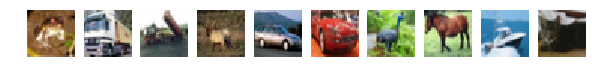

In [4]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [48]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [49]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [7]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
____________________________________________________

In [8]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.103


#### Train model with checkpoints

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [11]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoint/checkpoint'

checkpoint =  ModelCheckpoint(filepath=checkpoint_path, frequency='epoch',save_weights_only=True,verbose=1)


In [12]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model.fit(x=x_train,y=y_train,epochs=3, callbacks = [checkpoint])

Train on 10000 samples
Epoch 1/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.9560 - accuracy: 0.2847
Epoch 00001: saving model to model_checkpoint/checkpoint
10000/10000 [==============================] - 50s 5ms/sample - loss: 1.9562 - accuracy: 0.2844
Epoch 2/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.6242 - accuracy: 0.4174
Epoch 00002: saving model to model_checkpoint/checkpoint
10000/10000 [==============================] - 48s 5ms/sample - loss: 1.6247 - accuracy: 0.4170
Epoch 3/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.5090 - accuracy: 0.4579
Epoch 00003: saving model to model_checkpoint/checkpoint
10000/10000 [==============================] - 47s 5ms/sample - loss: 1.5093 - accuracy: 0.4578


In [13]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoint 

total 184K
-rw-r--r-- 1 jovyan users   77 Sep 30 14:41 checkpoint
-rw-r--r-- 1 jovyan users 174K Sep 30 14:41 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Sep 30 14:41 checkpoint.index


In [14]:
# Evaluate the performance of the trained model

get_test_accuracy(model,x_test,y_test)

accuracy: 0.452


#### Create new model, load weights

In [15]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model = get_new_model()
get_test_accuracy(model, x_test,y_test)

accuracy: 0.093


In [16]:
# Load weights -- accuracy is the same as the trained model

model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test,y_test)

accuracy: 0.452


#### Clear directory

In [18]:
! rm -r model_checkpoint

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [30]:
# Create Tensorflow checkpoint object with epoch and batch details
checkpoint_5000_path = \
   'model_checkpoints_5000/checkpoint_{epoch:02d}_{batch:04d}'
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path,
                                 save_weights_only=True,
                                 save_freq=5000,
                                  verbose=1)


In [31]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x=x_train,
         y=y_train,
         epochs=3,
         validation_data=(x_test,y_test),
         batch_size=10,
         callbacks=[checkpoint_5000])

Train on 10000 samples, validate on 1000 samples
Epoch 1/3
 4990/10000 [=============>................] - ETA: 31s - loss: 1.9665 - accuracy: 0.2754
Epoch 00001: saving model to model_checkpoints_5000/checkpoint_01_0499
 9980/10000 [============================>.] - ETA: 0s - loss: 1.8052 - accuracy: 0.3380
Epoch 00001: saving model to model_checkpoints_5000/checkpoint_01_0999
10000/10000 [==============================] - 63s 6ms/sample - loss: 1.8049 - accuracy: 0.3381 - val_loss: 1.5354 - val_accuracy: 0.4560
Epoch 2/3
 4990/10000 [=============>................] - ETA: 29s - loss: 1.5153 - accuracy: 0.4535
Epoch 00002: saving model to model_checkpoints_5000/checkpoint_02_0499
 9990/10000 [============================>.] - ETA: 0s - loss: 1.4787 - accuracy: 0.4671
Epoch 00002: saving model to model_checkpoints_5000/checkpoint_02_0999
10000/10000 [==============================] - 62s 6ms/sample - loss: 1.4788 - accuracy: 0.4671 - val_loss: 1.3902 - val_accuracy: 0.5150
Epoch 3/3
 49

In [32]:
# Have a look at what the checkpoint creates
! ls -lh model_checkpoints_5000


total 1.1M
-rw-r--r-- 1 jovyan users   93 Sep 30 15:43 checkpoint
-rw-r--r-- 1 jovyan users 174K Sep 30 15:41 checkpoint_01_0499.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Sep 30 15:41 checkpoint_01_0499.index
-rw-r--r-- 1 jovyan users 174K Sep 30 15:41 checkpoint_01_0999.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Sep 30 15:41 checkpoint_01_0999.index
-rw-r--r-- 1 jovyan users 174K Sep 30 15:42 checkpoint_02_0499.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Sep 30 15:42 checkpoint_02_0499.index
-rw-r--r-- 1 jovyan users 174K Sep 30 15:42 checkpoint_02_0999.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Sep 30 15:42 checkpoint_02_0999.index
-rw-r--r-- 1 jovyan users 174K Sep 30 15:43 checkpoint_03_0499.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Sep 30 15:43 checkpoint_03_0499.index
-rw-r--r-- 1 jovyan users 174K Sep 30 15:43 checkpoint_03_0999.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Sep 30 15:43 checkpoint_03_0999.index


#### Work with model saving criteria

In [33]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [34]:
# Create a new instance of untrained model
model = get_new_model()


In [37]:
# Create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path = 'model_checkpoints_best/checkpoint'

checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                                save_weights_only=True,
                                save_freq='epoch',
                                monitor='val_accuracy',
                                save_best_only=True,
                                verbose=1)


In [38]:
# Fit the model and save only the weights with the highest validation accuracy

history = model.fit(x=x_train,y=y_train,
                   epochs=50,
                   validation_data=(x_test,y_test),
                   batch_size=10,
                   callbacks=[checkpoint_best],
                   verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.09000, saving model to model_checkpoints_best/checkpoint

Epoch 00002: val_accuracy improved from 0.09000 to 0.10000, saving model to model_checkpoints_best/checkpoint

Epoch 00003: val_accuracy did not improve from 0.10000

Epoch 00004: val_accuracy did not improve from 0.10000

Epoch 00005: val_accuracy did not improve from 0.10000

Epoch 00006: val_accuracy did not improve from 0.10000

Epoch 00007: val_accuracy did not improve from 0.10000

Epoch 00008: val_accuracy improved from 0.10000 to 0.13000, saving model to model_checkpoints_best/checkpoint

Epoch 00009: val_accuracy did not improve from 0.13000

Epoch 00010: val_accuracy improved from 0.13000 to 0.15000, saving model to model_checkpoints_best/checkpoint

Epoch 00011: val_accuracy improved from 0.15000 to 0.17000, saving model to model_checkpoints_best/checkpoint

Epoch 00012: val_accuracy did not improve from 0.17000

Epoch 00013: val_accuracy did not improve from 0.17000


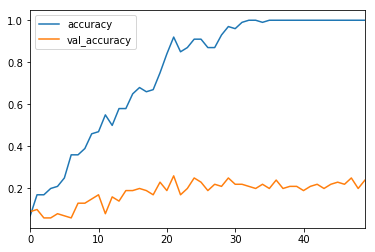

In [39]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [40]:
# Inspect the checkpoint directory
! ls -lh model_checkpoints_best


total 184K
-rw-r--r-- 1 jovyan users   77 Sep 30 15:57 checkpoint
-rw-r--r-- 1 jovyan users 174K Sep 30 15:57 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Sep 30 15:57 checkpoint.index


In [41]:
# Create a new model with the saved weights

new_model = get_new_model()

new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.260


#### Clear directory

In [45]:
! rm -r model_checkpoints_5000 model_checkpoints_best

rm: cannot remove 'model_checkpoints_5000': No such file or directory
rm: cannot remove 'model_checkpoints_best': No such file or directory


***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [50]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints'
checkpoint =  ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=False,
                             frequency = 'epoch',
                             verbose=1)

In [51]:
# Create and fit model with checkpoint
model = get_new_model()
model.fit(x=x_train,
         y=y_train,
         epochs=3,
         callbacks=[checkpoint])


Train on 10000 samples
Epoch 1/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.9518 - accuracy: 0.2834
Epoch 00001: saving model to model_checkpoints
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_checkpoints/assets
10000/10000 [==============================] - 55s 5ms/sample - loss: 1.9514 - accuracy: 0.2836
Epoch 2/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.6480 - accuracy: 0.4042
Epoch 00002: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
10000/10000 [==============================] - 46s 5ms/sample - loss: 1.6481 - accuracy: 0.4043
Epoch 3/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.5428 - accuracy: 0.4430
Epoch 00003: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
10000/10000 [==============================] - 48s 5ms/sample - loss: 1.5427 - accurac

#### Inspect what the checkpoint has created

In [52]:
# Have a look at what the checkpoint creates
! ls -lh model_checkpoints


total 128K
drwxr-xr-x 2 jovyan users 6.0K Sep 30 16:19 assets
-rw-r--r-- 1 jovyan users 119K Sep 30 16:21 saved_model.pb
drwxr-xr-x 2 jovyan users 6.0K Sep 30 16:21 variables


In [53]:
# Enter variables directory
! ls -lh model_checkpoints/variables


total 184K
-rw-r--r-- 1 jovyan users 177K Sep 30 16:21 variables.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.1K Sep 30 16:21 variables.index


In [54]:
# Get the model's test accuracy
get_test_accuracy(model, x_test, y_test)


accuracy: 0.438


#### Create new model from scratch

In [55]:
# Delete model
del model


In [56]:
from tensorflow.keras.models import load_model

In [57]:
# Reload model from scratch
model = load_model(checkpoint_path)
get_test_accuracy(model,x_test,y_test)


accuracy: 0.438


#### Use the .h5 format to save model

In [58]:
# Save the model in .h5 format
model.save('my_model.h5')


In [59]:
# Inspect .h5 file
! ls -lh my_model.h5

-rw-r--r-- 1 jovyan users 77K Sep 30 16:29 my_model.h5


In [60]:
# Delete model

del model

In [62]:
# Reload model from scratch

model = load_model('my_model.h5')

get_test_accuracy(model,x_test,y_test)


accuracy: 0.438


#### Clear directory

In [63]:
! rm -r model_checkpoints
! rm my_model.h5

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Keras HDF5 format. If you want to import it on your personal machine, use the following code:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In this coding tutorial, you will instead load the model directly from disk.

In [2]:
from tensorflow.keras.models import load_model

In [5]:
# Build Keras ResNet50 model
model = load_model('models/Keras_ResNet50.h5')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### Import and preprocess 3 sample images

In [6]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('data/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('data/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('data/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [7]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

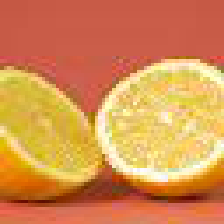

In [8]:
# Display image
lemon_img


In [10]:
# Display top 5 predictions
get_top_5_predictions(lemon_img)

40960/35363 [==================================] - 0s 0us/step


,prediction,probability
1,consomme,0.227801
2,lemon,0.221758
3,eggnog,0.151335
4,ladle,0.0400883
5,spotlight,0.0291972


##### Image 2: viaduct

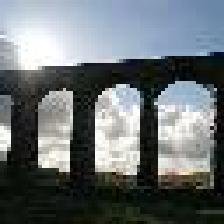

In [11]:
# Display image
viaduct_img


In [12]:
# Display top 5 predictions
get_top_5_predictions(viaduct_img)


,prediction,probability
1,vault,0.367951
2,prison,0.111742
3,viaduct,0.110738
4,window_screen,0.0882307
5,fire_screen,0.0206752


##### Image 3: water tower

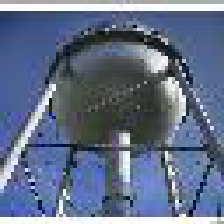

In [13]:
# Display image

water_tower_img

In [14]:
# Display top 5 predictions

get_top_5_predictions(water_tower_img)

,prediction,probability
1,solar_dish,0.384681
2,ladle,0.196179
3,planetarium,0.116682
4,strainer,0.04999
5,jigsaw_puzzle,0.0219473
